In [4]:
!pip install fbprophet

In [5]:
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import io, base64, os, json, re, glob
import datetime
from datetime import timedelta
import pandas as pd
import pydata_google_auth
import numpy as np
sns.set()

from fbprophet import Prophet
import statsmodels.api as sm

In [6]:
path = '/content/drive/My Drive/'
#file = 'SCADA_data_WT2339.csv'
file = 'SCADA_data_WT2339.csv'
df_raw = pd.read_csv(path+file,
                   low_memory=False)
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'], format="%Y/%m/%d %H:%M:%S")
df_raw = df_raw.sort_values(by='date_time')
df_raw.tail()

,id,ld_id,date_time,fake_data,NumSampleTenMinBin,AcumGralPala1Mean,AcumGralPala1Sdev,AcumGralPala1Min,AcumGralPala1Max,AcumGralPala2Mean,AcumGralPala2Sdev,AcumGralPala2Min,AcumGralPala2Max,AcumGralPala3Mean,AcumGralPala3Sdev,AcumGralPala3Min,AcumGralPala3Max,AutopilotoCalc,CmdWTGMean,CmdWTGSdev,CmdWTGMin,CmdWTGMax,ConfirmContractGiroCCWMean,ConfirmContractGiroCCWSdev,ConfirmContractGiroCCWMin,ConfirmContractGiroCCWMax,ConfirmContractGiroCWMean,ConfirmContractGiroCWSdev,ConfirmContractGiroCWMin,ConfirmContractGiroCWMax,ContEnerActivaMean,ContEnerActivaSdev,ContEnerActivaMin,ContEnerActivaMax,CosPhiMean,CosPhiSdev,CosPhiMin,CosPhiMax,Diag1_R4Mean,Diag1_R4Sdev,...,TempRodamTraseroMin,TempRodamTraseroMax,TempTrafo1Mean,TempEjeLento_2,TempEjeLento_1,TempTrafo1Sdev,TempTrafo1Min,TempTrafo1Max,TempTrafo2Mean,TempTrafo2Sdev,TempTrafo2Min,TempTrafo2Max,TempTrafo3Mean,TempTrafo3Sdev,TempTrafo3Min,TempTrafo3Max,TensRedMean,TensRedSdev,TensRedMin,TensRedMax,TotPotReactMean,TotPotReactSdev,TotPotReactMin,TotPotReactMax,VelGenMean,VelGenSdev,VelGenMin,VelGenMax,VelRotorMean,VelRotorSdev,VelRotorMin,VelRotorMax,VelVientoMean,VelVientoSdev,VelVientoMin,VelVientoMax,YawMean,YawSdev,YawMin,YawMax
357985,9173441,2339,2019-10-28 00:10:00,0,600,217.553,5.43567,210.865,228.383,218.616,4.58660,214.561,227.419,220.587,4.28259,217.454,228.544,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,537403000.0,0.0,537403000.0,537403000.0,45918300.0,9.46146,45918300.0,45918400.0,-0.977123,0.000926,-0.978727,-0.975519,-50.0,0.0,...,24.0093,24.0213,52.6869,NaN,NaN,0.024507,52.6445,52.7294,46.8990,0.008829,46.8837,46.9143,48.5933,0.008955,48.5778,48.6088,11929.2,8.57113,11914.4,11944.0,-34.8210,4.43113,-48.0000,-22.0,798.714,17.11430,778.0,857.800,12.0709,0.366804,11.5621,13.0600,6.24955,0.389556,5.38850,7.36314,182.778,0.404155,182.0,183.000
357986,9173442,2339,2019-10-28 00:20:00,0,600,219.036,5.61607,210.704,230.151,221.064,5.42083,211.347,229.187,223.591,4.84243,212.633,230.472,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,537403000.0,0.0,537403000.0,537403000.0,45918400.0,9.79266,45918400.0,45918400.0,-0.980331,0.000926,-0.981935,-0.978727,-50.0,0.0,...,24.0213,24.0333,52.6020,NaN,NaN,0.024507,52.5596,52.6445,46.8684,0.008829,46.8531,46.8837,48.5622,0.008955,48.5467,48.5778,11899.5,8.57113,11884.7,11914.4,-36.5022,1.20661,-39.0000,-35.0,794.328,8.63615,774.6,813.800,12.0428,0.208221,11.5600,12.6600,6.28515,0.280902,5.40523,6.99713,183.148,0.523093,182.0,184.000
357987,9173443,2339,2019-10-28 00:30:00,0,600,216.686,4.27313,210.704,230.151,220.516,3.04582,216.329,229.347,223.396,2.33984,220.347,230.633,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,537403000.0,0.0,537403000.0,537403000.0,45918400.0,8.74717,45918400.0,45918400.0,-0.986304,0.002305,-0.987647,-0.981935,-50.0,0.0,...,24.0333,24.0453,52.5172,NaN,NaN,0.024507,52.4747,52.5596,46.8378,0.008829,46.8225,46.8531,48.5312,0.008955,48.5157,48.5467,11918.2,21.64530,11878.0,11933.5,-32.8672,2.18205,-36.9221,-23.0,781.629,6.50745,769.7,796.113,11.7507,0.074996,11.6300,11.9788,6.11240,0.292124,5.30534,6.91170,183.029,0.081730,183.0,183.393
357988,9173444,2339,2019-10-28 00:40:00,0,600,217.796,5.02761,210.865,230.633,219.985,3.65141,216.490,229.669,222.149,3.32777,219.704,231.115,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,537403000.0,0.0,537403000.0,537403000.0,45918400.0,9.35378,45918400.0,45918400.0,-0.987659,NaN,-0.987671,-0.987647,-50.0,0.0,...,24.0453,24.0870,52.4323,NaN,NaN,0.024507,52.3898,52.4747,46.8073,0.008829,46.7920,46.8225,48.5002,0.008955,48.4847,48.5157,11937.1,2.12420,11933.5,11940.8,-35.1558,1.95447,-38.0000,-31.0,798.935,14.75060,780.1,839.000,12.1077,0.261321,11.6300,13.0100,6.37564,0.398907,5.08243,7.27639,182.761,0.522876,182.0,184.000
357989,9173445,2339,2019-10-28 00:50:00,0,600,218.484,5.35927,210.704,230.312,221.021,5.89803,213.115,229.347,223.260,6.13660,214.079,230.633,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,537403000.0,0.0,537403000.0,537403000.0,45918500.0,9.35349,45918400.0,45918500.0,-0.987683,NaN,-0.987695,-0.987671,-50.0,0

In [7]:
df_raw.head()

,id,ld_id,date_time,fake_data,NumSampleTenMinBin,AcumGralPala1Mean,AcumGralPala1Sdev,AcumGralPala1Min,AcumGralPala1Max,AcumGralPala2Mean,AcumGralPala2Sdev,AcumGralPala2Min,AcumGralPala2Max,AcumGralPala3Mean,AcumGralPala3Sdev,AcumGralPala3Min,AcumGralPala3Max,AutopilotoCalc,CmdWTGMean,CmdWTGSdev,CmdWTGMin,CmdWTGMax,ConfirmContractGiroCCWMean,ConfirmContractGiroCCWSdev,ConfirmContractGiroCCWMin,ConfirmContractGiroCCWMax,ConfirmContractGiroCWMean,ConfirmContractGiroCWSdev,ConfirmContractGiroCWMin,ConfirmContractGiroCWMax,ContEnerActivaMean,ContEnerActivaSdev,ContEnerActivaMin,ContEnerActivaMax,CosPhiMean,CosPhiSdev,CosPhiMin,CosPhiMax,Diag1_R4Mean,Diag1_R4Sdev,...,TempRodamTraseroMin,TempRodamTraseroMax,TempTrafo1Mean,TempEjeLento_2,TempEjeLento_1,TempTrafo1Sdev,TempTrafo1Min,TempTrafo1Max,TempTrafo2Mean,TempTrafo2Sdev,TempTrafo2Min,TempTrafo2Max,TempTrafo3Mean,TempTrafo3Sdev,TempTrafo3Min,TempTrafo3Max,TensRedMean,TensRedSdev,TensRedMin,TensRedMax,TotPotReactMean,TotPotReactSdev,TotPotReactMin,TotPotReactMax,VelGenMean,VelGenSdev,VelGenMin,VelGenMax,VelRotorMean,VelRotorSdev,VelRotorMin,VelRotorMax,VelVientoMean,VelVientoSdev,VelVientoMin,VelVientoMax,YawMean,YawSdev,YawMin,YawMax
0,7735936,2339,2013-01-01 00:00:00,0,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7735937,2339,2013-01-01 00:10:00,0,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7735938,2339,2013-01-01 00:20:00,0,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7735939,2339,2013-01-01 00:30:00,0,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7735940,2339,2013-01-01 00:40:00,0,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


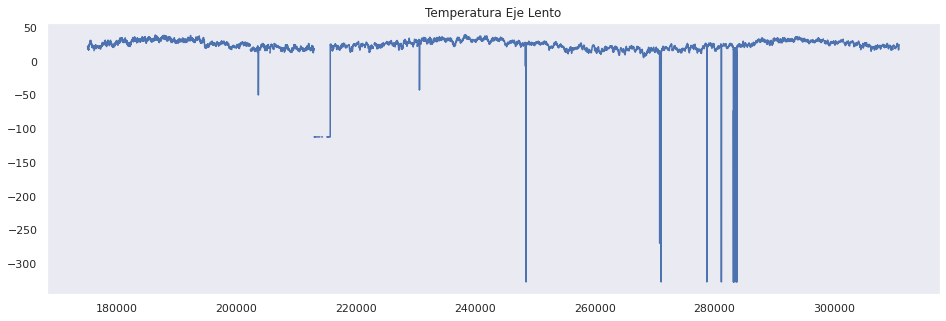

In [8]:
plt.subplots(1, figsize = (16, 5))
plt.grid()
plt.title('Temperatura Eje Lento')
#plt.plot(df_raw['TempEjeLento_1'].rolling(window=150).median())
plt.plot(df_raw['TempEjeLento_1'])

In [9]:
train_dataset = df_raw[['date_time', 'TempEjeLento_1','TempAmbMean','IndTurbulMean','VelVientoMean','VelVientoSdev']]
train_dataset.columns = ["ds", "y",'TempAmbMean','IndTurbulMean','VelVientoMean','VelVientoSdev']
train_dataset=train_dataset.dropna()
train_dataset.head()

,ds,y,TempAmbMean,IndTurbulMean,VelVientoMean,VelVientoSdev
175116,2016-05-01 02:00:00,21.9728,9.50351,5.19300,4.29626,0.546738
175117,2016-05-01 02:10:00,21.9186,9.37979,4.69699,4.38668,0.516368
175118,2016-05-01 02:20:00,21.7681,9.25607,4.21163,5.02184,0.411032
175119,2016-05-01 02:30:00,21.6371,9.13236,4.43174,5.01911,0.346268
175120,2016-05-01 02:40:00,21.5035,9.00864,4.59329,4.11904,0.466578


In [10]:
def remove_outliers(df):
    return df[np.abs(df['y']-df['y'].mean())<=(3*df['y'].std())] 

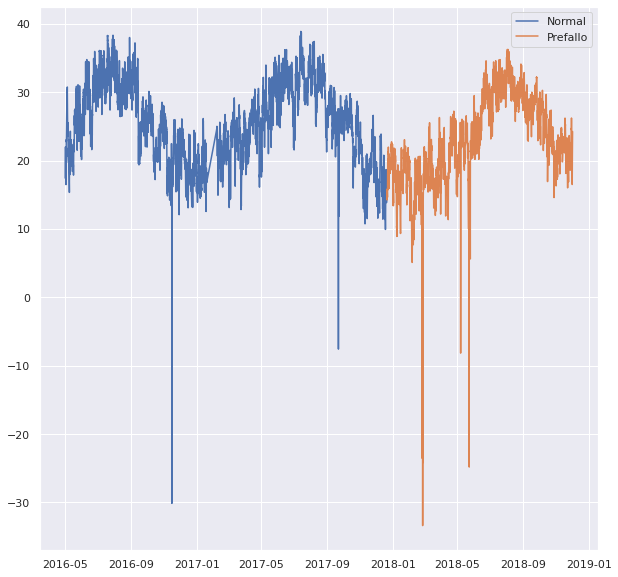

In [11]:
date = '2017-12-21'
date_fail = '2018-05-21'
data_1 = train_dataset[(train_dataset['ds'] < date)]
data_1 = remove_outliers(data_1)

data_2 = train_dataset[(train_dataset['ds'] > date)]
data_2 = remove_outliers(data_2)

data_test = train_dataset[(train_dataset['ds'] < date_fail)]
#data_test = data_test[(data_test['ds'] < date_fail)]
data_test = remove_outliers(data_test)
plt.figure(figsize=(10,10))
plt.plot(data_1['ds'],data_1['y'],label='Normal')
plt.plot(data_2['ds'],data_2['y'],label='Prefallo')
plt.legend()
plt.show()

In [12]:
#prophet_basic = Prophet(yearly_seasonality=True)
prophet_basic = Prophet()
prophet_basic.add_regressor('TempAmbMean')
prophet_basic.add_regressor('IndTurbulMean')
prophet_basic.add_regressor('VelVientoMean')
prophet_basic.add_regressor('VelVientoSdev')
prophet_basic.fit(data_1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


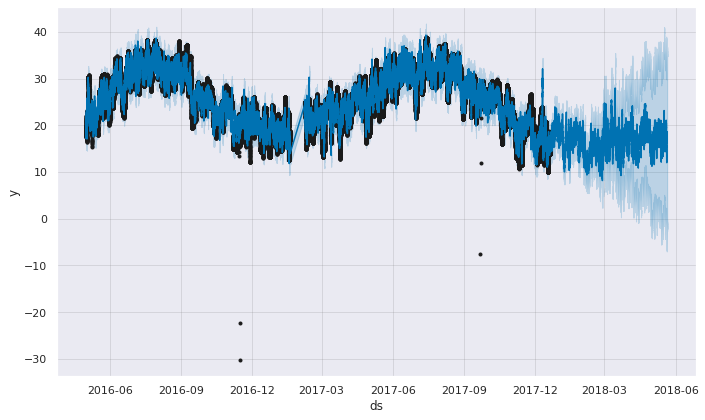

In [13]:
forecast=prophet_basic.predict(data_test.drop(columns="y"))

#Plotting the predicted data
fig1 =prophet_basic.plot(forecast)

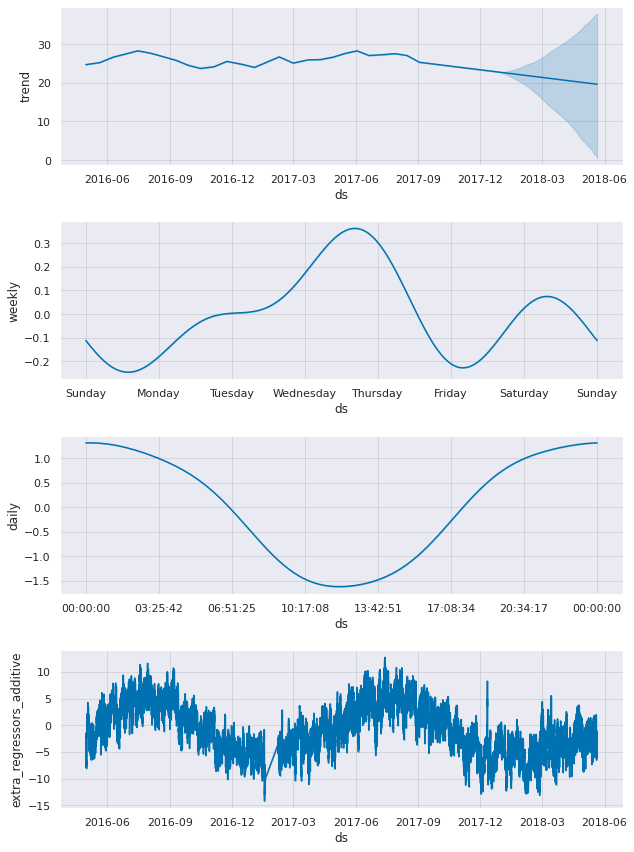

In [14]:
fig1 = prophet_basic.plot_components(forecast)

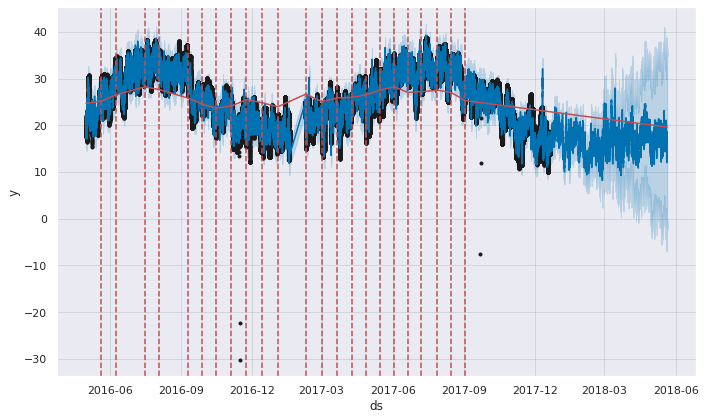

In [15]:
from fbprophet.plot import add_changepoints_to_plot
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)

In [16]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,IndTurbulMean,IndTurbulMean_lower,IndTurbulMean_upper,TempAmbMean,TempAmbMean_lower,TempAmbMean_upper,VelVientoMean,VelVientoMean_lower,VelVientoMean_upper,VelVientoSdev,VelVientoSdev_lower,VelVientoSdev_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
100605,2018-05-20 23:10:00,19.622215,-1.875228,34.953411,0.652340,37.773885,-0.107245,-0.107245,-0.107245,-3.128860,-3.128860,-3.128860,-0.360014,-0.360014,-0.360014,-0.023784,-0.023784,-0.023784,-2.528736,-2.528736,-2.528736,1.280218,1.280218,1.280218,-3.619904,-3.619904,-3.619904,-0.189051,-0.189051,-0.189051,0.0,0.0,0.0,17.093479
100606,2018-05-20 23:20:00,19.622064,-1.516108,34.821639,0.651182,37.775265,-0.092894,-0.092894,-0.092894,-3.140592,-3.140592,-3.140592,-0.280564,-0.280564,-0.280564,-0.021768,-0.021768,-0.021768,-2.434138,-2.434138,-2.434138,1.288928,1.288928,1.288928,-3.535819,-3.535819,-3.535819,-0.187247,-0.187247,-0.187247,0.0,0.0,0.0,17.187926
100607,2018-05-20 23:30:00,19.621913,-1.756375,35.973140,0.650025,37.776646,-0.078521,-0.078521,-0.078521,-3.152375,-3.152375,-3.152375,-0.256363,-0.256363,-0.256363,-0.017683,-0.017683,-0.017683,-2.394113,-2.394113,-2.394113,1.296255,1.296255,1.296255,-3.504941,-3.504941,-3.504941,-0.185426,-0.185426,-0.185426,0.0,0.0,0.0,17.227800
100608,2018-05-20 23:40:00,19.621762,-2.279970,35.296942,0.648868,37.778027,-0.100879,-0.100879,-0.100879,-3.164107,-3.164107,-3.164107,-0.290479,-0.290479,-0.290479,-0.017372,-0.017372,-0.017372,-2.454320,-2.454320,-2.454320,1.302107,1.302107,1.302107,-3.572838,-3.572838,-3.572838,-0.183589,-0.183589,-0.183589,0.0,0.0,0.0,17.167442
100609,2018-05-20 23:50:00,19.621611,-1.857792,34.476331,0.647711,37.779407,-0.033188,-0.033188,-0.033188,-3.175840,-3.175840,-3.175840,-0.818674,-0.818674,-0.818674,-0.009069,-0.009069,-0.009069,-2.912111,-2.912111,-2.912111,1.306394,1.306394,1.306394,-4.036770,-4.036770,-4.036770,-0.181736,-0.181736,-0.181736,0.0,0.0,0.0,16.709500


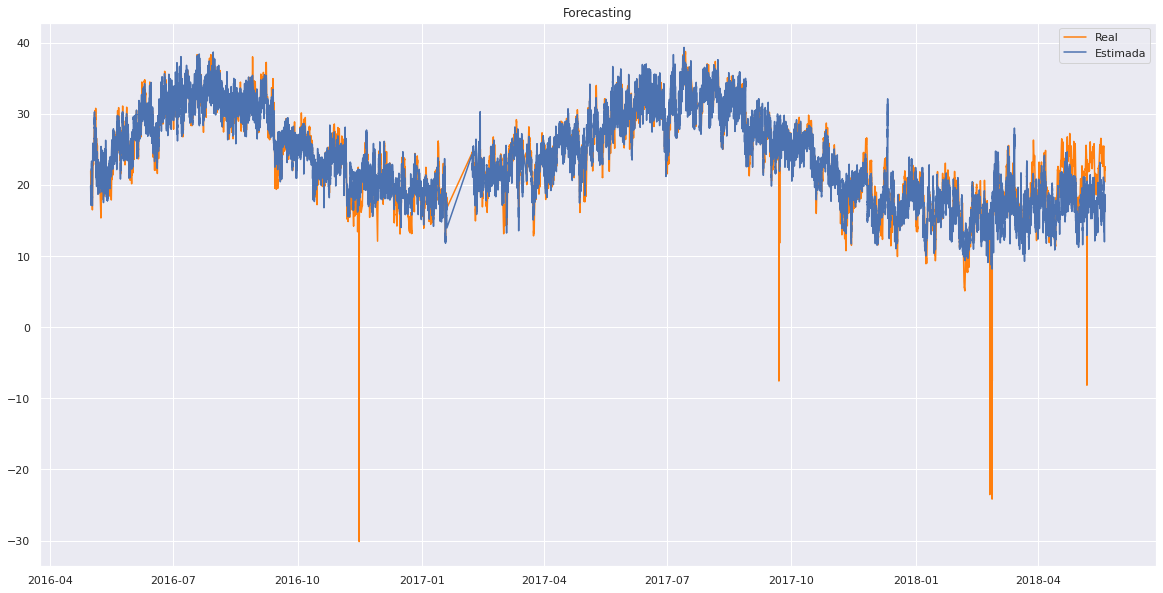

In [17]:
plt.figure(figsize=(20,10))
#plt.plot(forecast['ds'],forecast['yhat_lower'],'-r',label='Confianza')
#plt.plot(forecast['ds'],forecast['yhat_upper'],'-r')
plt.plot(data_test['ds'],data_test['y'],'tab:orange',label='Real')
plt.plot(forecast['ds'],forecast['yhat'],'b',label='Estimada')
#plt.plot(data_1['ds'],data_1['y'],'c')
plt.legend()
plt.title('Forecasting')
plt.show()

In [18]:
import numpy as np
forecast['error']= data_test['y']-forecast['yhat']

In [19]:
data_test.head()

,ds,y,TempAmbMean,IndTurbulMean,VelVientoMean,VelVientoSdev
175116,2016-05-01 02:00:00,21.9728,9.50351,5.19300,4.29626,0.546738
175117,2016-05-01 02:10:00,21.9186,9.37979,4.69699,4.38668,0.516368
175118,2016-05-01 02:20:00,21.7681,9.25607,4.21163,5.02184,0.411032
175119,2016-05-01 02:30:00,21.6371,9.13236,4.43174,5.01911,0.346268
175120,2016-05-01 02:40:00,21.5035,9.00864,4.59329,4.11904,0.466578


In [20]:
forecast['y_true'] = data_test['y'].values
forecast['error'] = forecast['y_true']-forecast['yhat']

In [21]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,IndTurbulMean,IndTurbulMean_lower,IndTurbulMean_upper,TempAmbMean,TempAmbMean_lower,TempAmbMean_upper,VelVientoMean,VelVientoMean_lower,VelVientoMean_upper,VelVientoSdev,VelVientoSdev_lower,VelVientoSdev_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,error,y_true
0,2016-05-01 02:00:00,24.680958,17.529603,22.409021,24.680958,24.680958,0.094465,0.094465,0.094465,-4.813069,-4.813069,-4.813069,-1.174715,-1.174715,-1.174715,-0.013181,-0.013181,-0.013181,-4.849576,-4.849576,-4.849576,1.200894,1.200894,1.200894,-5.906500,-5.906500,-5.906500,-0.143970,-0.143970,-0.143970,0.0,0.0,0.0,19.831382,2.141418,21.9728
1,2016-05-01 02:10:00,24.681127,17.307573,22.070567,24.681127,24.681127,0.047362,0.047362,0.047362,-4.875905,-4.875905,-4.875905,-1.131089,-1.131089,-1.131089,-0.014585,-0.014585,-0.014585,-4.939636,-4.939636,-4.939636,1.181106,1.181106,1.181106,-5.974217,-5.974217,-5.974217,-0.146524,-0.146524,-0.146524,0.0,0.0,0.0,19.741491,2.177109,21.9186
2,2016-05-01 02:20:00,24.681295,17.371680,22.159680,24.681295,24.681295,0.001270,0.001270,0.001270,-4.938742,-4.938742,-4.938742,-0.824637,-0.824637,-0.824637,-0.019455,-0.019455,-0.019455,-4.770640,-4.770640,-4.770640,1.159983,1.159983,1.159983,-5.781564,-5.781564,-5.781564,-0.149059,-0.149059,-0.149059,0.0,0.0,0.0,19.910655,1.857445,21.7681
3,2016-05-01 02:30:00,24.681464,17.190246,22.209984,24.681464,24.681464,0.022173,0.022173,0.022173,-5.001573,-5.001573,-5.001573,-0.825954,-0.825954,-0.825954,-0.022450,-0.022450,-0.022450,-4.841783,-4.841783,-4.841783,1.137595,1.137595,1.137595,-5.827804,-5.827804,-5.827804,-0.151574,-0.151574,-0.151574,0.0,0.0,0.0,19.839681,1.797419,21.6371
4,2016-05-01 02:40:00,24.681633,16.965702,21.829400,24.681633,24.681633,0.037514,0.037514,0.037514,-5.064409,-5.064409,-5.064409,-1.260220,-1.260220,-1.260220,-0.016887,-0.016887,-0.016887,-5.344068,-5.344068,-5.344068,1.114001,1.114001,1.114001,-6.304002,-6.304002,-6.304002,-0.154068,-0.154068,-0.154068,0.0,0.0,0.0,19.337565,2.165935,21.5035


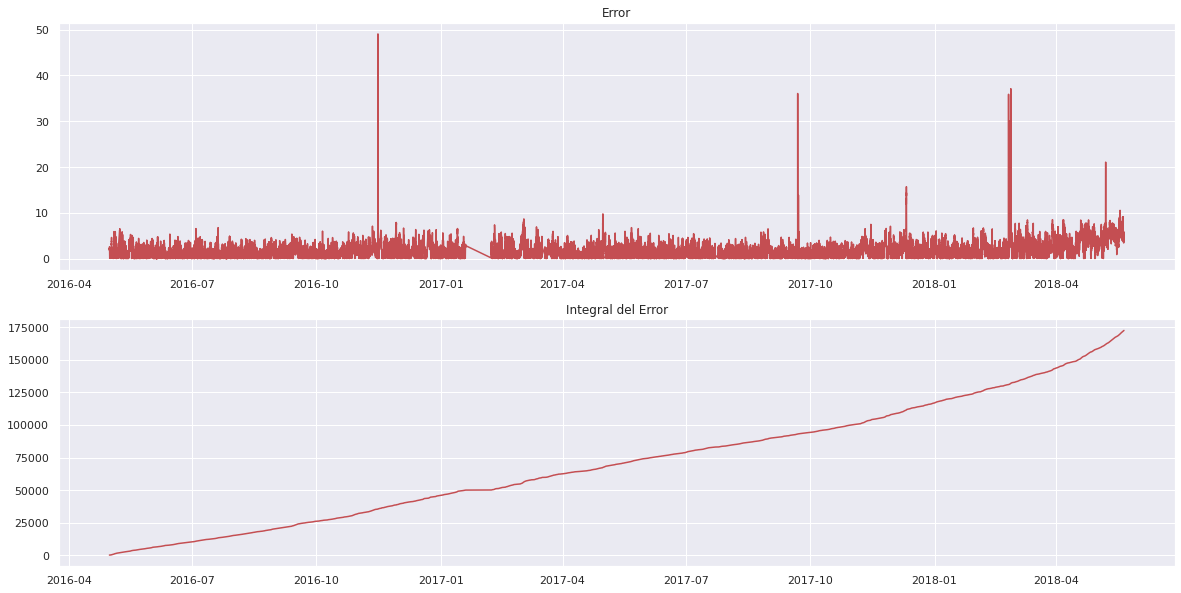

In [27]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.title('Error')
plt.plot(forecast['ds'],forecast['error'].abs(),'r')
plt.subplot(212)
plt.title('Integral del Error')
plt.plot(forecast['ds'],forecast['error'].abs().cumsum(),'r')

plt.show()

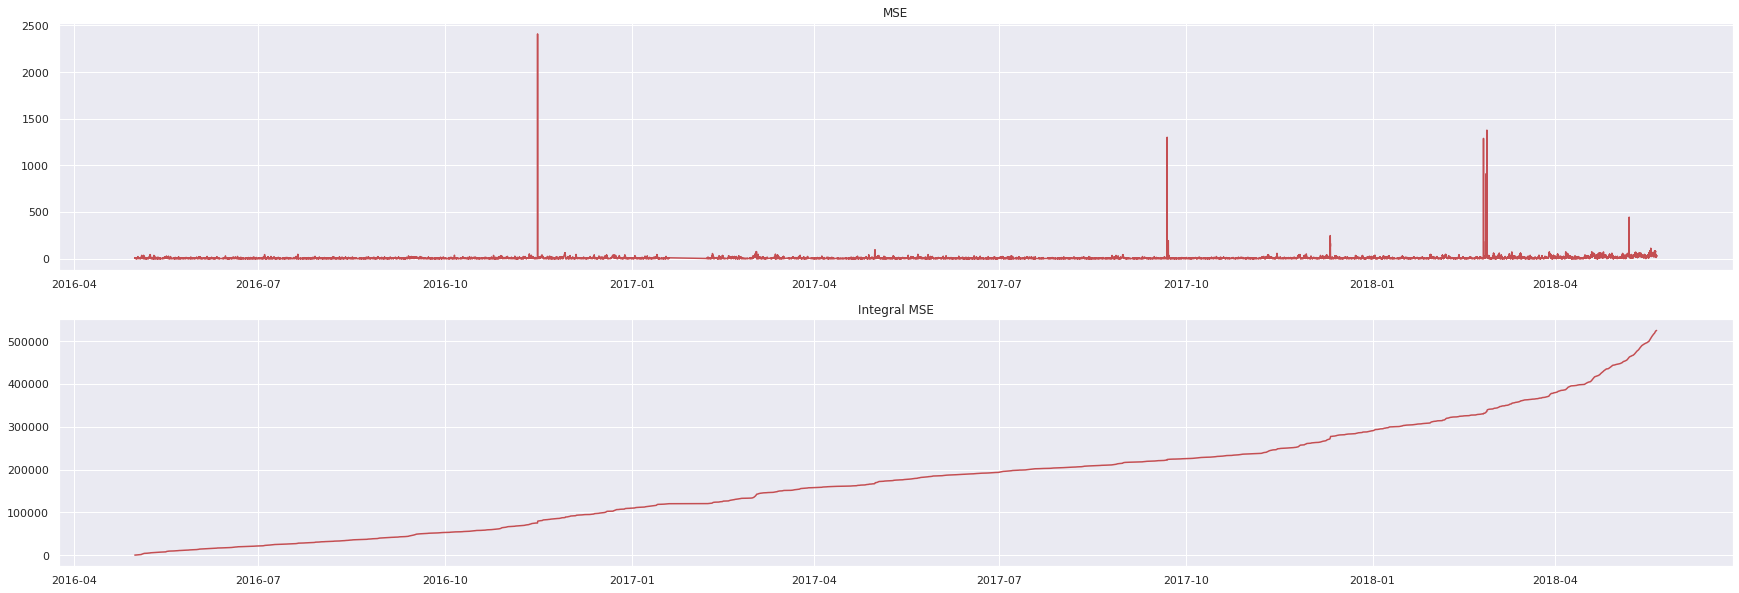

In [26]:
signal = forecast['error']**2
plt.figure(figsize=(30,10))
plt.subplot(211)
plt.plot(forecast['ds'],signal,'r')
plt.title('MSE')
plt.subplot(212)
signal=forecast['error']**2
plt.plot(forecast['ds'],signal.cumsum(),'r')
plt.title('Integral MSE')
plt.show()